In [1]:
#in this notebook, we will cluster publishers for different common languages in our item data set.
#the distance between cluster centroids can be used as one componenet in our recommender system
# Importing necessary libraries
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from nltk.tokenize import RegexpTokenizer
from scipy.spatial.distance import cdist
import re
import string
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Import dataset
books_data = pd.read_csv('D:/Uni Mannheim/Semester 2/Data Mining 2/DMC/final_improv_ver2.csv', sep=',')
df = books_data.copy()

In [3]:
#as we can see, there is no NaN values for publishers in our dataset thanks to the preprocessing step that we have conducted
df['publisher'].isna().sum()

0

In [4]:
#as we can see here, the distribution of languages in our data set is as follows:
#English: 54%, German 38%, Spanish 4%, Italian 1%, French 1%
#we only do clustering for these five most common languages in our dataset
#our approach mainly relies on the description attribute

lang_type = df.groupby('language',sort = False).agg({'itemID': 'count'}).reset_index()
lang_type.sort_values(by=['itemID'], ascending=False, inplace=True, ignore_index= True)
threshold = 900
m = lang_type['itemID'] < threshold
lang_type1 = lang_type[~m].append(lang_type.loc[m, ['itemID']].sum(), ignore_index=True)
lang_type1.at[5,'language'] = 'other langs'
print(lang_type1)

      language   itemID
0           en  42445.0
1           de  28785.0
2           es   3435.0
3           it    977.0
4           fr    914.0
5  other langs   1474.0


In [5]:
#here we simply divide our dataset w.r.t languages
df_de = df[df['language'] == 'de']
df_temp = df[df['language'] != 'de']
df_en = df_temp[df_temp['language'] == 'en']
df_temp = df_temp[df_temp['language'] != 'en']
df_es = df_temp[df_temp['language'] == 'es']
df_temp = df_temp[df_temp['language'] != 'es']
df_it = df_temp[df_temp['language'] == 'it']
df_temp = df_temp[df_temp['language'] != 'it']
df_fr = df_temp[df_temp['language'] == 'fr']
df_rem = df_temp[df_temp['language'] != 'fr'] 

#Note that we are going to concatanate all descriptions that we have for each publisher.
#But there are items with NaN description. To acoid erros, we substitute all NaN values
# in description attribute with empty strings ''
df_de['description'] = df_de['description'].fillna('')
df_en['description'] = df_en['description'].fillna('')
df_es['description'] = df_es['description'].fillna('')
df_it['description'] = df_it['description'].fillna('')
df_fr['description'] = df_fr['description'].fillna('')
df_rem['description'] = df_fr['description'].fillna('')

#df_de_nan = df_de[df_de['description'].isnull()]
#df_en_nan = df_en[df_en['description'].isnull()]
#df_es_nan = df_es[df_es['description'].isnull()]
#df_it_nan = df_it[df_it['description'].isnull()]
#df_fr_nan = df_fr[df_fr['description'].isnull()]

#df_de = df_de.dropna(subset=['description'])
#df_en = df_en.dropna(subset=['description'])
#df_es = df_es.dropna(subset=['description'])
#df_it = df_it.dropna(subset=['description'])
#df_fr = df_fr.dropna(subset=['description'])

<ipython-input-5-8a9908f44703>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_de['description'] = df_de['description'].fillna('')
<ipython-input-5-8a9908f44703>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fr['description'] = df_fr['description'].fillna('')
<ipython-input-5-8a9908f44703>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [6]:
#print the number of distinct publishers in each of these subsets of our data
print('number of disting publishers in en:', len(pd.unique(df_en['publisher'])))
print('number of disting publishers in de:', len(pd.unique(df_de['publisher'])))
print('number of disting publishers in es:', len(pd.unique(df_es['publisher'])))
print('number of disting publishers in it:', len(pd.unique(df_it['publisher'])))
print('number of disting publishers in fr:', len(pd.unique(df_fr['publisher'])))

number of disting publishers in en: 5177
number of disting publishers in de: 2848
number of disting publishers in es: 457
number of disting publishers in it: 144
number of disting publishers in fr: 218


In [7]:
#now we concatanate all descriptions that we have for each publisher.
df_de_concat = df_de.groupby(['publisher'])['description'].apply(','.join).reset_index()
df_en_concat = df_en.groupby(['publisher'])['description'].apply(','.join).reset_index()
df_es_concat = df_es.groupby(['publisher'])['description'].apply(','.join).reset_index()
df_it_concat = df_it.groupby(['publisher'])['description'].apply(','.join).reset_index()
df_fr_concat = df_fr.groupby(['publisher'])['description'].apply(','.join).reset_index()

In [9]:
# Function for removing NonAscii characters
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# Function for converting into lower case
def make_lower_case(text):
    return text.lower()

# Function for removing stop words
def remove_stop_words(text, item_lang):
    if item_lang in lang_in_nltk:
        text = text.split()
        stops = set(stopwords.words(item_lang)) #change to other language #"english"
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    return text

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

# Function for removing the html tags
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [10]:
#here, we preprocess documents that we collected with predefined functions.
#note that we still does not use the stop word removal. #is it only available for English?

for i in range (len(df_en_concat.index)):
    processesed_description = df_en_concat.at[i,'description']
    processesed_description = _removeNonAscii(processesed_description)
    processesed_description = make_lower_case(processesed_description)
    processesed_description = remove_punctuation(processesed_description)
    processesed_description = remove_html(processesed_description)
    df_en_concat.loc[i, 'description'] = processesed_description

for i in range (len(df_de_concat.index)):
    processesed_description = df_de_concat.at[i,'description']
    processesed_description = _removeNonAscii(processesed_description)
    processesed_description = make_lower_case(processesed_description)
    processesed_description = remove_punctuation(processesed_description)
    processesed_description = remove_html(processesed_description)
    df_de_concat.loc[i, 'description'] = processesed_description

    
for i in range (len(df_es_concat.index)):
    processesed_description = df_es_concat.at[i,'description']
    processesed_description = _removeNonAscii(processesed_description)
    processesed_description = make_lower_case(processesed_description)
    processesed_description = remove_punctuation(processesed_description)
    processesed_description = remove_html(processesed_description)
    df_es_concat.loc[i, 'description'] = processesed_description
    
for i in range (len(df_it_concat.index)):
    processesed_description = df_it_concat.at[i,'description']
    processesed_description = _removeNonAscii(processesed_description)
    processesed_description = make_lower_case(processesed_description)
    processesed_description = remove_punctuation(processesed_description)
    processesed_description = remove_html(processesed_description)
    df_it_concat.loc[i, 'description'] = processesed_description
    
for i in range (len(df_fr_concat.index)):
    processesed_description = df_fr_concat.at[i,'description']
    processesed_description = _removeNonAscii(processesed_description)
    processesed_description = make_lower_case(processesed_description)
    processesed_description = remove_punctuation(processesed_description)
    processesed_description = remove_html(processesed_description)
    df_fr_concat.loc[i, 'description'] = processesed_description

In [10]:
#We start with publisher clustering for German language.
vec = TfidfVectorizer()
vec.fit(df_de_concat.description.values)
features = vec.transform(df_de_concat.description.values)

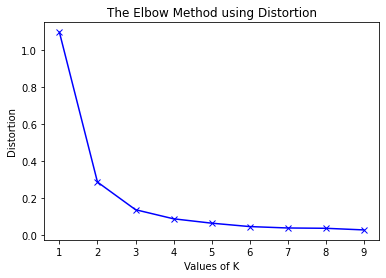

In [11]:
#in this section we use elbow method to find out about number of required clusters in German language.

# reduce the features to 2D
pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(features.toarray())

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeans = KMeans(n_clusters=k, random_state=0).fit(reduced_features)
    distortions.append(sum(np.min(cdist(reduced_features, kmeans.cluster_centers_,
                                        'cosine'), axis=1)) / reduced_features.shape[0])
    inertias.append(kmeans.inertia_)
 
    mapping1[k] = sum(np.min(cdist(reduced_features, kmeans.cluster_centers_,
                                   'cosine'), axis=1)) / reduced_features.shape[0]
    mapping2[k] = kmeans.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

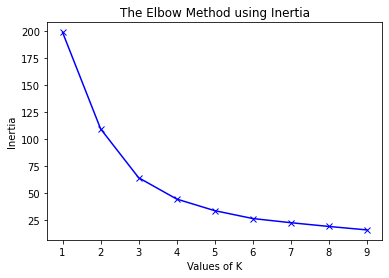

In [12]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [13]:
#using elbow method we can conclude that k=3 is a good choice. However, if we apply k=3, and look at the cosine
#similarity matirx we can see that cosine similarity of two clusters is 0.99. Such distinction is not useful.
#so, we will continue with k=2
kmeans = KMeans(n_clusters=2, random_state=0).fit(features)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [14]:
#We collect cosine similarity of the centroids in a 2D array to be used by our RS.
cosine_sim_pub_de = np.ndarray(shape=(2,2), dtype=np.ndarray, order='F')
for i in range (2):
    for j in range (2):
        # Dot and norm
        dot = sum(a*b for a, b in zip(centers[i], centers[j]))
        norm_a = sum(a*a for a in centers[i]) ** 0.5
        norm_b = sum(b*b for b in centers[j]) ** 0.5
        # Cosine similarity
        cos_sim = dot / (norm_a*norm_b)
        cosine_sim_pub_de[i,j] = cos_sim

In [15]:
print(cosine_sim_pub_de)

[[1.0 0.31513736784729934]
 [0.31513736784729934 1.0]]


In [16]:
df_de_concat['publisher_cluster'] = labels.tolist()
df_de_concat_copy = df_de_concat.copy() 
df_de_concat.drop(['description'], axis= 1, inplace=True)
df_de = df_de.merge(df_de_concat, on='publisher')
df_de.drop(['Unnamed: 0'], axis= 1, inplace=True)
df_de.head(1)

,itemID,title,author,publisher,main topic,subtopics,language,description,interest_age,number_pages,release_date,ISBN_13,publisher_cluster
0,73018,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]",de,,1,{224},{Timestamp('2020-12-02 00:00:00')},"[{'type': 'ISBN_10', 'identifier': '3849927601...",0


In [17]:
pub_type = df_de.groupby('publisher_cluster',sort = False).agg({'itemID': 'count'}).reset_index()
pub_type.sort_values(by=['itemID'], ascending=False, inplace=True, ignore_index= True)
print(pub_type)

   publisher_cluster  itemID
0                  0   25368
1                  1    4044


In [18]:
df_de_main = df_de[df_de['publisher_cluster'] == 0]
df_de_rem = df_de[df_de['publisher_cluster'] != 0]
df_de_concat_copy = df_de_concat_copy[df_de_concat_copy['publisher_cluster'] == 0]

In [19]:
#Now, we will continue our clustring focusing on the main cluster for German language.
vec = TfidfVectorizer()
vec.fit(df_de_concat_copy.description.values)
features = vec.transform(df_de_concat_copy.description.values)

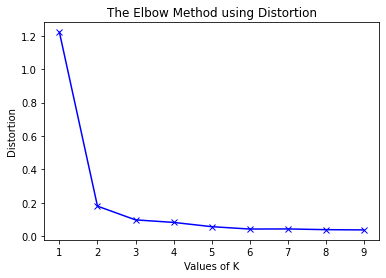

In [20]:
#in this section we use elbow method to find out about number of required clusters in German language.

# reduce the features to 2D
pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(features.toarray())

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeans = KMeans(n_clusters=k, random_state=0).fit(reduced_features)
    distortions.append(sum(np.min(cdist(reduced_features, kmeans.cluster_centers_,
                                        'cosine'), axis=1)) / reduced_features.shape[0])
    inertias.append(kmeans.inertia_)
 
    mapping1[k] = sum(np.min(cdist(reduced_features, kmeans.cluster_centers_,
                                   'cosine'), axis=1)) / reduced_features.shape[0]
    mapping2[k] = kmeans.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

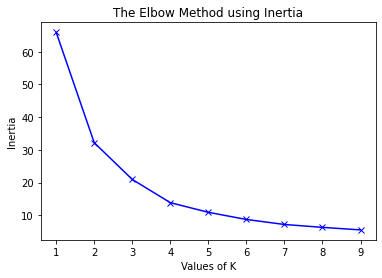

In [21]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [22]:
#using elbow method we can conclude that k=2 or k=3 or k=4 is a good choice.
#however, if we apply k=3 or k=2 we can see that cosine similarity of two clusters is equal to 0.98.
#such distinction is not useful for our evaluation. it seems that two clusters are really similar to
#each other anyway!, so we will continue with 3 clusters in order to isolate corner points as much as we can.
#through experiment we can see that if we keep k=4 then one cluster will only includes 7 books, which is not desirable

kmeans = KMeans(n_clusters=3, random_state=0).fit(features)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [23]:
#We collect cosine similarity of the centroids in a 2D array to be used by our RS.
cosine_sim_pub_de_lev2 = np.ndarray(shape=(3,3), dtype=np.ndarray, order='F')
for i in range (3):
    for j in range (3):
        # Dot and norm
        dot = sum(a*b for a, b in zip(centers[i], centers[j]))
        norm_a = sum(a*a for a in centers[i]) ** 0.5
        norm_b = sum(b*b for b in centers[j]) ** 0.5
        # Cosine similarity
        cos_sim = dot / (norm_a*norm_b)
        cosine_sim_pub_de_lev2[i,j] = cos_sim

In [24]:
print(cosine_sim_pub_de_lev2)

[[1.0 0.8542686054060038 0.8246997999672416]
 [0.8542686054060038 1.0 0.9813799242789548]
 [0.8246997999672416 0.9813799242789548 1.0]]


In [25]:
df_de_concat_copy['publisher_cluster_level2'] = labels.tolist()
df_de_concat_copy.drop(['description','publisher_cluster'], axis= 1, inplace=True)
df_de_main = df_de_main.merge(df_de_concat_copy, on='publisher')
df_de_main.head(1)

,itemID,title,author,publisher,main topic,subtopics,language,description,interest_age,number_pages,release_date,ISBN_13,publisher_cluster,publisher_cluster_level2
0,73018,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]",de,,1,{224},{Timestamp('2020-12-02 00:00:00')},"[{'type': 'ISBN_10', 'identifier': '3849927601...",0,0


In [26]:
pub_type = df_de_main.groupby('publisher_cluster_level2',sort = False).agg({'itemID': 'count'}).reset_index()
pub_type.sort_values(by=['itemID'], ascending=False, inplace=True, ignore_index= True)
print(pub_type)

   publisher_cluster_level2  itemID
0                         2   19500
1                         0    3459
2                         1    2409


In [27]:
df_de_rem['publisher_cluster_level2']= np.nan

<ipython-input-27-702c3c9c185d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_de_rem['publisher_cluster_level2']= np.nan


In [28]:
df_de_rem.head(1)

,itemID,title,author,publisher,main topic,subtopics,language,description,interest_age,number_pages,release_date,ISBN_13,publisher_cluster,publisher_cluster_level2
6893,54393,Picklewitch & Jack and the Cuckoo Cousin,Claire Barker,Faber & Faber,YFH,"[5AF,YFQ,YFS]",de,DR FIRENZE SHARPTOOTH cordially invites ST IMA...,0.5,{240},{Timestamp('2019-09-05 00:00:00')},"[{'type': 'ISBN_13', 'identifier': '9780571335...",1,NaN


In [29]:
frames = [df_de_rem, df_de_main]
df_de = pd.concat(frames)

In [30]:
df_de.head(1)

,itemID,title,author,publisher,main topic,subtopics,language,description,interest_age,number_pages,release_date,ISBN_13,publisher_cluster,publisher_cluster_level2
6893,54393,Picklewitch & Jack and the Cuckoo Cousin,Claire Barker,Faber & Faber,YFH,"[5AF,YFQ,YFS]",de,DR FIRENZE SHARPTOOTH cordially invites ST IMA...,0.5,{240},{Timestamp('2019-09-05 00:00:00')},"[{'type': 'ISBN_13', 'identifier': '9780571335...",1,NaN


In [31]:
df_de.tail(1)

,itemID,title,author,publisher,main topic,subtopics,language,description,interest_age,number_pages,release_date,ISBN_13,publisher_cluster,publisher_cluster_level2
25367,23731,Verlorene Schwestern,Oliver Bendel,Leipziger Literaturverlag,FL,[],de,dresden wahrscheinlich ein paar monate in der ...,None,{116},{Timestamp('2009-07-29 00:00:00')},"[{'type': 'ISBN_10', 'identifier': '140631823X...",0,1.0


In [33]:
#to use this function, pass two itemid! the first one should be the query item, and the second its counter part
def similarity_pub_de(itemID1, itemID2):
    #Find the query item
    query_index = int(df[df['itemID'] == itemID1].index.values)
    #metadata for the query item
    query_metadata = df.iloc[query_index].copy()
    
    #Find the counter part
    counterpart_index = int(df[df['itemID'] == itemID2].index.values)
    #metadata for the query item
    counterpart_metadata = df.iloc[counterpart_index].copy()
    
    if (query_metadata.publisher_cluster != counterpart.publisher_cluster):
        similarity = 0.315*0.315
    elif (query_metadata.publisher_cluster == 1):
        similarity = 1
    else:
        if (query_metadata.publisher_cluster_level2 == counterpart_metadata.publisher_cluster_level2):
            similarity = 1
        elif ((query_metadata.publisher_cluster_level2 ==0 and ounterpart_metadata.publisher_cluster_level2 ==1) or
              (query_metadata.publisher_cluster_level2 ==1 and ounterpart_metadata.publisher_cluster_level2 ==0)):
            similarity = 0.85
        elif ((query_metadata.publisher_cluster_level2 ==0 and ounterpart_metadata.publisher_cluster_level2 ==2) or
              (query_metadata.publisher_cluster_level2 ==2 and ounterpart_metadata.publisher_cluster_level2 ==0)):
            similarity = 0.82
        elif ((query_metadata.publisher_cluster_level2 ==2 and ounterpart_metadata.publisher_cluster_level2 ==1) or
              (query_metadata.publisher_cluster_level2 ==1 and ounterpart_metadata.publisher_cluster_level2 ==2)):
            similarity = 0.98   
    return similarity

In [34]:
vec = TfidfVectorizer(stop_words="english")
vec.fit(df_en_concat.description.values)
features = vec.transform(df_en_concat.description.values)

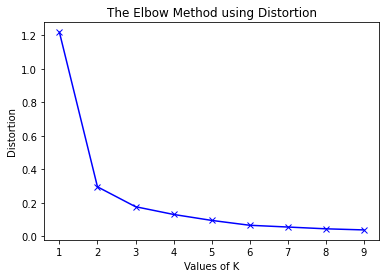

In [35]:
#in this section we use elbow method to find out about number of required clusters in English language.

# reduce the features to 2D
pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(features.toarray())

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeans = KMeans(n_clusters=k, random_state=0).fit(reduced_features)
    distortions.append(sum(np.min(cdist(reduced_features, kmeans.cluster_centers_,
                                        'cosine'), axis=1)) / reduced_features.shape[0])
    inertias.append(kmeans.inertia_)
 
    mapping1[k] = sum(np.min(cdist(reduced_features, kmeans.cluster_centers_,
                                   'cosine'), axis=1)) / reduced_features.shape[0]
    mapping2[k] = kmeans.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

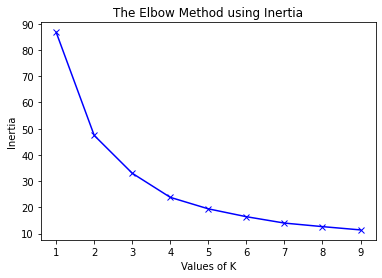

In [36]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [40]:
#using elbow method we can conclude that k=2 can be good candidates.

kmeans = KMeans(n_clusters=3, random_state=0).fit(features)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [41]:
#We collect cosine similarity of the centroids in a 2D array to be used by our RS.
cosine_sim_pub_en = np.ndarray(shape=(3,3), dtype=np.ndarray, order='F')
for i in range (3):
    for j in range (3):
        # Dot and norm
        dot = sum(a*b for a, b in zip(centers[i], centers[j]))
        norm_a = sum(a*a for a in centers[i]) ** 0.5
        norm_b = sum(b*b for b in centers[j]) ** 0.5
        # Cosine similarity
        cos_sim = dot / (norm_a*norm_b)
        cosine_sim_pub_en[i,j] = cos_sim

In [42]:
print(cosine_sim_pub_en)

[[1.0 0.9415939950061173 0.8227850179271008]
 [0.9415939950061173 1.0 0.8935010167424665]
 [0.8227850179271008 0.8935010167424665 1.0]]


In [43]:
df_en_concat['publisher_cluster'] = labels.tolist()
df_en_concat.drop(['description'], axis= 1, inplace=True)
df_en = df_en.merge(df_en_concat, on='publisher')

In [44]:
pub_type = df_en.groupby('publisher_cluster',sort = False).agg({'itemID': 'count'}).reset_index()
pub_type.sort_values(by=['itemID'], ascending=False, inplace=True, ignore_index= True)
print(pub_type)

   publisher_cluster  itemID
0                  1   27493
1                  2    8409
2                  0    5980


In [24]:
vec = TfidfVectorizer()
vec.fit(df_es_concat.description.values)
features = vec.transform(df_es_concat.description.values)

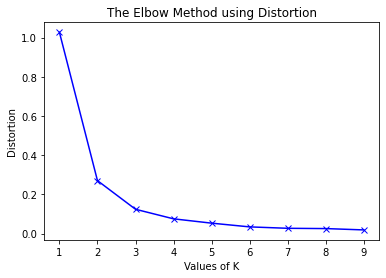

In [25]:
#in this section we use elbow method to find out about number of required clusters in English language.

# reduce the features to 2D
pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(features.toarray())

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeans = KMeans(n_clusters=k, random_state=0).fit(reduced_features)
    distortions.append(sum(np.min(cdist(reduced_features, kmeans.cluster_centers_,
                                        'cosine'), axis=1)) / reduced_features.shape[0])
    inertias.append(kmeans.inertia_)
 
    mapping1[k] = sum(np.min(cdist(reduced_features, kmeans.cluster_centers_,
                                   'cosine'), axis=1)) / reduced_features.shape[0]
    mapping2[k] = kmeans.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

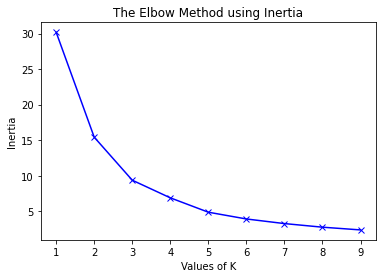

In [26]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [27]:
#using elbow method we can conclude that k=3 or k=5 can be good candidates.
#We will use k=5, and then later we can tune our model accoding to evaluation.

kmeans = KMeans(n_clusters=5, random_state=0).fit(features)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [28]:
#We collect cosine similarity of the centroids in a 2D array to be used by our RS.
cosine_sim_pub_es = np.ndarray(shape=(5,5), dtype=np.ndarray, order='F')
for i in range (5):
    for j in range (5):
        # Dot and norm
        dot = sum(a*b for a, b in zip(centers[i], centers[j]))
        norm_a = sum(a*a for a in centers[i]) ** 0.5
        norm_b = sum(b*b for b in centers[j]) ** 0.5
        # Cosine similarity
        cos_sim = dot / (norm_a*norm_b)
        cosine_sim_pub_es[i,j] = cos_sim

In [29]:
df_es_concat['publisher_cluster'] = labels.tolist()
df_es_concat.drop(['description'], axis= 1, inplace=True)
df_es = df_es.merge(df_es_concat, on='publisher')

In [30]:
pub_type = df_es.groupby('publisher_cluster',sort = False).agg({'itemID': 'count'}).reset_index()
pub_type.sort_values(by=['itemID'], ascending=False, inplace=True, ignore_index= True)
print(pub_type)

   publisher_cluster  itemID
0                  4    1737
1                  1    1060
2                  3     398
3                  0     142
4                  2      57


In [31]:
vec = TfidfVectorizer()
vec.fit(df_it_concat.description.values)
features = vec.transform(df_it_concat.description.values)

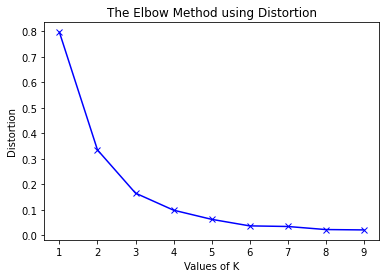

In [32]:
#in this section we use elbow method to find out about number of required clusters in English language.

# reduce the features to 2D
pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(features.toarray())

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeans = KMeans(n_clusters=k, random_state=0).fit(reduced_features)
    distortions.append(sum(np.min(cdist(reduced_features, kmeans.cluster_centers_,
                                        'cosine'), axis=1)) / reduced_features.shape[0])
    inertias.append(kmeans.inertia_)
 
    mapping1[k] = sum(np.min(cdist(reduced_features, kmeans.cluster_centers_,
                                   'cosine'), axis=1)) / reduced_features.shape[0]
    mapping2[k] = kmeans.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

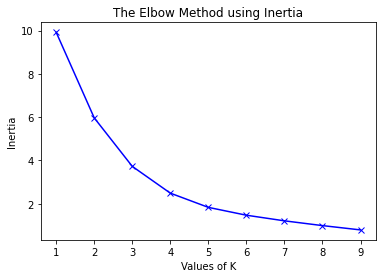

In [33]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [34]:
#using elbow method we can conclude that k=3 or k=5 can be good candidates.
#We will use k=5, and then later we can tune our model accoding to evaluation.

kmeans = KMeans(n_clusters=5, random_state=0).fit(features)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [35]:
#We collect cosine similarity of the centroids in a 2D array to be used by our RS.
cosine_sim_pub_it = np.ndarray(shape=(5,5), dtype=np.ndarray, order='F')
for i in range (5):
    for j in range (5):
        # Dot and norm
        dot = sum(a*b for a, b in zip(centers[i], centers[j]))
        norm_a = sum(a*a for a in centers[i]) ** 0.5
        norm_b = sum(b*b for b in centers[j]) ** 0.5
        # Cosine similarity
        cos_sim = dot / (norm_a*norm_b)
        cosine_sim_pub_it[i,j] = cos_sim

In [36]:
df_it_concat['publisher_cluster'] = labels.tolist()
df_it_concat.drop(['description'], axis= 1, inplace=True)
df_it = df_it.merge(df_es_concat, on='publisher')

In [37]:
pub_type = df_it.groupby('publisher_cluster',sort = False).agg({'itemID': 'count'}).reset_index()
pub_type.sort_values(by=['itemID'], ascending=False, inplace=True, ignore_index= True)
print(pub_type)

   publisher_cluster  itemID
0                  1     706
1                  4      76
2                  0      13
3                  3      12
4                  2      10
